In [2]:
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim


In [236]:

# Load your DataFrame
df = pd.read_pickle('gcse_specs_edit.pkl')
df

,File_Name,Author,Subject,Text,Processed_Text
0,168982-specification-gcse-mathematics.pdf,OCR,Mathematics,Qualification\nAccredited\nocr.org.uk/gcsemath...,first assessment mathematicsregistere office e...
1,168995-specification-accredited-gcse-english-l...,OCR,English Literature,Qualification\nAccredited\nH418\nFor first ass...,first assessment first assessment office exemp...
2,168996-specification-accredited-gcse-english-l...,OCR,English Language,Qualification\nAccredited\nocr.org.uk/gcseengl...,first assessment office exempt charity update ...
3,207163-specification-accredited-gcse-history-a...,OCR,History,H418\nFor first assessment 2022\nocr.org.uk/gc...,first assessment history explain accredit firs...
4,207164-specification-accredited-gcse-history-b...,OCR,History,In partnership \nwith\nH418\nFor first assess...,partnership first assessment history first ass...
...,...,...,...,...,...
66,specification-gcse2017-l12-urdu-issue5.pdf,Pearson Edexcel,Urdu,This draft qualification has not yet been accr...,draft qualification yet accredit publish enabl...
67,specification-pearson-edexcel-level-1-level-2-...,Pearson Edexcel,French,GCSE (9-1)\nFrench\nSpeciﬁ cation\nPearson Ed...,cation level first teach certiﬁ cation issue l...
68,specification-pearson-edexcel-level-1-level-2-...,Pearson Edexcel,German,GCSE (9-1)\nGerman\nSpeciﬁ cation\nPearson Ed...,cation level first teach certiﬁ cation issue l...
69,Specification-Pearson-Edexcel-Level-1-Level-2-...,Pearson Edexcel,Spanish,GCSE (9-1)\nSpanish\nSpeciﬁ cation\nPearson E...,cation level first teach certiﬁ cation issue l...


In [165]:
from gensim import corpora

# Step 1: Generate data_words
data_words = df['Processed_Text'].apply(lambda x: x.split()).tolist()

# Step 2: Create id2word dictionary
id2word = corpora.Dictionary(data_words)

# Step 3: Create the corpus
corpus = [id2word.doc2bow(text) for text in data_words]


In [167]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=75)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=75)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

remove_word = "signature"

# Filter out the specific word
data_bigrams_trigrams = [[word for word in doc if word != remove_word] for doc in data_bigrams_trigrams]

In [168]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.02
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [252]:
 lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=8,          
                                            random_state=750,      
                                            update_every=1,        
                                            chunksize=10,          
                                            passes=50,
                                             eta=0.001,
                                            alpha="auto")   

In [253]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\Asha\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.222606 -0.035950       1        1  27.491012
6     -0.182220  0.336549       2        1  22.110156
0      0.359413 -0.092729       3        1  11.974659
3      0.411361  0.221580       4        1  11.476143
7     -0.480822 -0.080025       5        1  10.904473
5      0.189145 -0.338991       6        1   6.897670
2      0.058829  0.444257       7        1   6.052092
4     -0.133100 -0.454691       8        1   3.093795, topic_info=            Term          Freq         Total Category  logprob  loglift
1115        tier  11028.000000  11028.000000  Default  30.0000  30.0000
608     language   2669.000000   2669.000000  Default  29.0000  29.0000
796    practical   3507.000000   3507.000000  Default  28.0000  28.0000
2028      medium   2237.000000   2237.000000  Default  27.0000  27.0000
202    component   2333.000000   2333.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
975     sequence     47.202062     88.877861   Topic8  -4.4765   2.8429
3130       brief     91.272502    429.897245   Topic8  -3.8171   1.9261
1327       genre     62.767842    212.224062   Topic8  -4.1915   2.2576
1589   listening     36.650858     88.091936   Topic8  -4.7295   2.5988
1594  moderation     35.673355    235.011340   Topic8  -4.7566   1.5905

[384 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2295      2  1.005786  academic_educational
3071      8  0.985862         accompaniment
29        6  0.999198     additionally_able
3769      1  0.999893             adjective
3770      1  0.998673                adverb
...     ...       ...                   ...
2624      2  0.999901                 water
2283      1  0.249078                 woman
2283      4  0.754154                 woman
1481      5  0.997085                writer
1482      5  1.000179               writing

[403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 4, 8, 6, 3, 5])

In [212]:

dictionary = corpora.Dictionary(data_words)

In [67]:
topic_distributions = lda_model.get_document_topics(corpus)
# Define the topic ID you are interested in
topic_id = 2

# Function to split text into sentences
def split_into_sentences(text):
    return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

# Function to find sentences with a specific word
def find_sentences_with_word(text, word):
    sentences = split_into_sentences(text)
    return [sentence for sentence in sentences if word in sentence]

# Initialize a list for results
results = []

# Iterate through each document to find sentences with 'nature'
for doc_id, doc_topics in enumerate(topic_distributions):
    # Check if the document is relevant to the specified topic
    topic_prob = dict(doc_topics).get(topic_id, 0)
        # Get the text for the document
        text = df.loc[doc_id, 'Text']
        
        # Get sentences containing 'nature'
        sentences_with_nature = find_sentences_with_word(text, 'nature')
        
        # Append sentences to results with metadata
        for sentence in sentences_with_nature:
            author = df.loc[doc_id, 'Author']
            subject = df.loc[doc_id, 'Subject']
            file_name = df.loc[doc_id, 'File_Name']
            
            results.append({
                'Document ID': doc_id,
                'Topic ID': topic_id,
                'Topic Probability': topic_prob,
                'Sentence': sentence,
                'Author': author,
                'Subject': subject,
                'File Name': file_name
            })

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)

# Print results
print(f"Sentences containing 'nature' for Topic {topic_id}:")
for _, row in results_df.iterrows():
    print(f"Document ID: {row['Document ID']}, Topic Probability: {row['Topic Probability']}")
    print(f"Author: {row['Author']}")
    print(f"Subject: {row['Subject']}")
    print(f"File Name: {row['File Name']}")
    print(f"Sentence: {row['Sentence']}")
    print("-" * 50)


Sentences containing 'nature' for Topic 1:
Document ID: 2, Topic Probability: 0.013540121726691723
Author: OCR
Subject: English Language
File Name: 168996-specification-accredited-gcse-english-language-j351.pdf
Sentence: The	unseen	
nature of the assessment encourages independent 
thought	and	response	and	requires	a	selective	
application	of	the	analytical	tools	necessary	for	critical	
evaluation	in	other	subjects.
--------------------------------------------------
Document ID: 7, Topic Probability: 0.04245379567146301
Author: OCR
Subject: Music
File Name: 219378-specification-accredited-gcse-music-j536.pdf
Sentence: Musical language •  Reading and writing of staff notation including treble-clef and bass-clef note 
names, rhythmic notation in simple time, key signatures to four sharps and 
four flats.
--------------------------------------------------
Document ID: 7, Topic Probability: 0.04245379567146301
Author: OCR
Subject: Music
File Name: 219378-specification-accredited-gcse-music-

In [147]:
 from gensim.models import CoherenceModel

# Assuming lda_model is your trained LDA model, and texts is your list of tokenized documents
coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()

coherence_model_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_cv = coherence_model_cv.get_coherence()

print(f'Coherence UMass: {coherence_umass}')
print(f'Coherence C_v: {coherence_cv}')

Coherence UMass: -3.042702196892147
Coherence C_v: 0.6081551763861133


In [256]:
# Print the top words for all topics to verify their numbers
for topic_id in range(lda_model.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))

Topic 0:
0.139*"medium" + 0.128*"component" + 0.065*"audience" + 0.049*"production" + 0.037*"meaning" + 0.032*"technique" + 0.028*"source" + 0.026*"non_exam" + 0.021*"brief" + 0.019*"drama"
Topic 1:
0.272*"tier" + 0.098*"speak" + 0.075*"vocabulary" + 0.069*"verb" + 0.059*"sentence" + 0.055*"r" + 0.055*"band" + 0.050*"theme" + 0.036*"noun" + 0.026*"grammar"
Topic 2:
0.058*"fieldwork" + 0.050*"human" + 0.047*"datum" + 0.045*"geographical" + 0.038*"global" + 0.034*"economic" + 0.034*"country" + 0.033*"investigate" + 0.030*"environment" + 0.028*"climate"
Topic 3:
0.085*"significance" + 0.080*"attitude" + 0.065*"history" + 0.050*"religious" + 0.046*"political" + 0.041*"conflict" + 0.034*"enquiry" + 0.031*"concept" + 0.028*"interpretation" + 0.028*"period"
Topic 4:
0.111*"music" + 0.093*"piece" + 0.078*"musical" + 0.062*"composition" + 0.049*"perform" + 0.035*"note" + 0.029*"musical_element" + 0.028*"instrument" + 0.028*"control" + 0.022*"brief"
Topic 5:
0.089*"simple" + 0.065*"tier" + 0.047

In [210]:
for word in words:
    word_id = dictionary.token2id.get(word, None)
    if word_id is not None:
        # Get the complete topic distribution for the word
        word_topic_probs = lda_model.get_term_topics(word_id, minimum_probability=0)
        print(f"Word '{word}' is in the vocabulary. Probabilities: {word_topic_probs}")
    else:
        print(f"Word '{word}' is not in the vocabulary.")


Word 'tier' is in the vocabulary. Probabilities: [(5, 0.0007904745)]


In [184]:
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

In [186]:
from collections import defaultdict

# Create a dictionary to hold top documents for each topic
topic_docs = defaultdict(list)

for doc_id, topics in enumerate(document_topics):
    for topic_id, prob in topics:
        topic_docs[topic_id].append((doc_id, prob))

# Sort the documents for each topic by probability in descending order
for topic_id in topic_docs:
    topic_docs[topic_id].sort(key=lambda x: x[1], reverse=True)

# Extract top N documents for each topic
N = 5
top_documents_per_topic = {topic_id: topic_docs[topic_id][:N] for topic_id in topic_docs}


In [232]:
print(df.columns)


Index(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5',
       'Topic 6', 'Topic 7'],
      dtype='object')


In [258]:
for topic_id, top_docs in top_documents_per_topic.items():
    # Add bold text and a separator line
    print(f"\033[1m{'=' * 40}\nTop documents for topic {topic_id}:\n{'=' * 40}\033[0m")
    for doc_id, prob in top_docs:
        author = df.loc[doc_id, 'Author']  
        subject = df.loc[doc_id, 'Subject'] 
        file_name = df.loc[doc_id, 'File_Name']
        
        print(f"Document ID: {doc_id}, Probability: {prob}")
        print(f"Author: {author}")
        print(f"Subject: {subject}")
        print(f"File Name: {file_name}")
        print()


Top documents for topic 5:
Document ID: 0, Probability: 0.9970136284828186
Author: OCR
Subject: Mathematics
File Name: 168982-specification-gcse-mathematics.pdf

Document ID: 42, Probability: 0.9637722969055176
Author: Pearson Edexcel
Subject: Unknown
File Name: gcse-maths-2015-specification.pdf

Document ID: 46, Probability: 0.6549975275993347
Author: Pearson Edexcel
Subject: Computer Science
File Name: GCSE_L1_L2_Computer_Science_2020_Specification.pdf

Document ID: 39, Probability: 0.517759382724762
Author: Pearson Edexcel
Subject: Astronomy
File Name: gcse-astronomy-specification.pdf

Document ID: 38, Probability: 0.5063188076019287
Author: Pearson Edexcel
Subject: Statistics
File Name: gcse-9-1-statistics-specification.pdf

Top documents for topic 0:
Document ID: 32, Probability: 0.9215993881225586
Author: OCR
Subject: Media Studies
File Name: 687701-specification-accredited-gcse-media-studies-j200.pdf

Document ID: 30, Probability: 0.9190781116485596
Author: OCR
Subject: Media St

In [95]:
import re
import pandas as pd

# Define the function to find and highlight sentences with a specific word
def find_sentences_with_word(doc, word):
    # Split the document into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', doc)
    highlighted_sentences = []
    # Iterate over each sentence
    for sentence in sentences:
        if word.lower() in sentence.lower():
            # Highlight the word by wrapping it with ANSI escape codes
            highlighted_sentence = re.sub(f"(?i)({word})", r'\033[91m\1\033[0m', sentence)
            highlighted_sentences.append(highlighted_sentence)
    return highlighted_sentences

# Initialize a list for results
results = []

# Define the topic ID you are interested in
topic_id = 2

# Get topic probabilities for each document
topic_distributions = lda_model.get_document_topics(corpus)

# Iterate through each document to find and highlight sentences with 'nature'
for doc_id, doc_topics in enumerate(topic_distributions):
    # Check if the document is relevant to the specified topic
    topic_prob = dict(doc_topics).get(topic_id, 0)
    if topic_prob > 0:  # Consider only documents with non-zero probability for the topic
        # Get the text for the document
        text = df.loc[doc_id, 'Text']
        
        # Get and highlight sentences containing 'nature'
        highlighted_sentences = find_sentences_with_word(text, 'nature')
        
        # Append highlighted sentences to results with metadata
        for sentence in highlighted_sentences:
            author = df.loc[doc_id, 'Author']
            subject = df.loc[doc_id, 'Subject']
            file_name = df.loc[doc_id, 'File_Name']
            
            results.append({
                'Document ID': doc_id,
                'Topic ID': topic_id,
                'Topic Probability': topic_prob,
                'Sentence': sentence,
                'Author': author,
                'Subject': subject,
                'File Name': file_name
            })

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)

# Print results
print(f"Sentences containing and highlighting 'nature' for Topic {topic_id}:")
for _, row in results_df.iterrows():
    print(f"Document ID: {row['Document ID']}, Topic Probability: {row['Topic Probability']}")
    print(f"Author: {row['Author']}")
    print(f"Subject: {row['Subject']}")
    print(f"File Name: {row['File Name']}")
    print(f"Sentence: {row['Sentence']}")
    print("-" * 50)


Sentences containing and highlighting 'nature' for Topic 2:
Document ID: 3, Topic Probability: 0.01563039980828762
Author: OCR
Subject: History
File Name: 207163-specification-accredited-gcse-history-a-first-teaching-2019-with-first-assessment-2021-j410.pdf
Sentence: Communism	in	China	after	the	
death of Mao 1976–1981Attitudes to opposition and its repression after 1976, including the 
Gang of Four and the ‘democracy wall’; changes in economic policy 
under Deng and its impact, including the Four Modernisations; the 
nature of Communist propaganda and its impact; social changes 
under Deng and its impact, including the role of women, changes in 
education and the One Child policy.2 Version 1.8 © OCR 2024  
14 GCSE (9–1) in History AGermany	1925–1955:	The	People	and	the	State	(J410/02)
This depth study focuses on the relationship between 
the German people and the Nazi regime that ruled 
Germany from 1933–1945.
--------------------------------------------------
Document ID: 3, Topic Pr

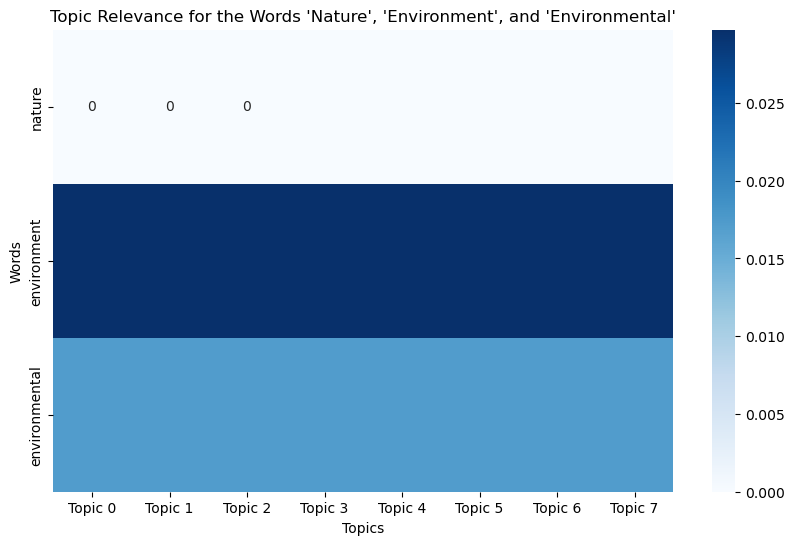

In [234]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of words to analyze
words_to_analyze = ['nature', 'environment', 'environmental']

# Dictionary to store topic probabilities for each word
word_probabilities = {}

# Extract topic probabilities for each word
for word in words_to_analyze:
    if word in id2word.token2id:
        word_id = id2word.token2id[word]
        # Extract probabilities for all topics and store them, even if they are zero
        probabilities = [prob for _, prob in lda_model.get_term_topics(word_id, minimum_probability=0)]
        # If no probabilities found, fill with zeros
        if len(probabilities) == 0:
            probabilities = [0] * lda_model.num_topics
        word_probabilities[word] = probabilities
    else:
        print(f"Word '{word}' not found in dictionary.")
        word_probabilities[word] = [0] * lda_model.num_topics  # Fill with zeros if word not found

# Create a DataFrame from the word probabilities
vis_df = pd.DataFrame(word_probabilities, index=[f'Topic {i}' for i in range(lda_model.num_topics)])

# Transpose the DataFrame for easier plotting
vis_df = df.T

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="Blues")
plt.title("Topic Relevance for the Words 'Nature', 'Environment', and 'Environmental'")
plt.xlabel("Topics")
plt.ylabel("Words")
plt.show()


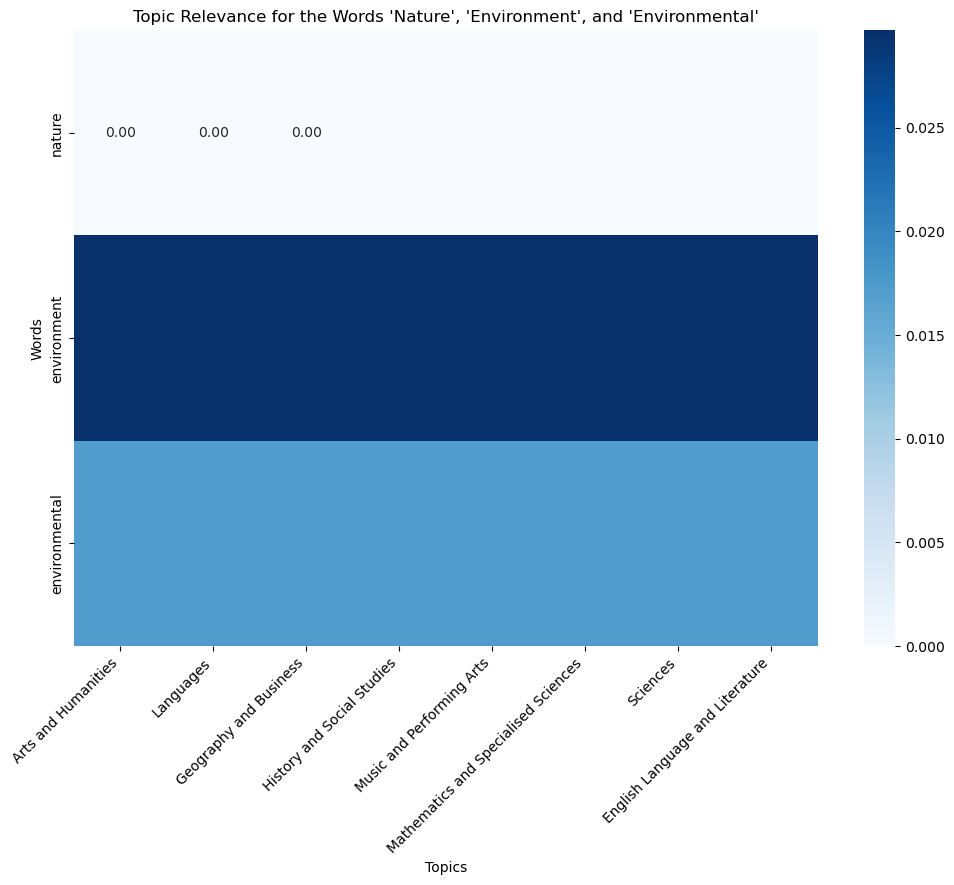

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of words to analyze
words_to_analyze = ['nature', 'environment', 'environmental']

# Dictionary to store topic probabilities for each word
word_probabilities = {}

# Extract topic probabilities for each word
for word in words_to_analyze:
    if word in id2word.token2id:
        word_id = id2word.token2id[word]
        # Extract probabilities for all topics and store them, even if they are zero
        probabilities = [prob for _, prob in lda_model.get_term_topics(word_id, minimum_probability=0)]
        # If no probabilities found, fill with zeros
        if len(probabilities) == 0:
            probabilities = [0] * lda_model.num_topics
        word_probabilities[word] = probabilities
    else:
        print(f"Word '{word}' not found in dictionary.")
        word_probabilities[word] = [0] * lda_model.num_topics  # Fill with zeros if word not found

# Create a DataFrame from the word probabilities
vis_df = pd.DataFrame(word_probabilities, index=[f'Topic {i}' for i in range(lda_model.num_topics)])

# Transpose the DataFrame for easier plotting
vis_df = vis_df.T

# Define the topic labels
topic_labels = {
    0: "Arts and Humanities",
    1: "Languages",
    2: "Geography and Business",
    3: "History and Social Studies",
    4: "Music and Performing Arts",
    5: "Mathematics and Specialised Sciences",
    6: "Sciences",
    7: "English Language and Literature"
}

# Rename the columns in the DataFrame to include the topic labels
vis_df.columns = [topic_labels.get(int(col.split(' ')[1]), col) for col in vis_df.columns]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(vis_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Topic Relevance for the Words 'Nature', 'Environment', and 'Environmental'")
plt.xlabel("Topics")
plt.ylabel("Words")
plt.xticks(rotation=45, ha='right') 
plt.show()


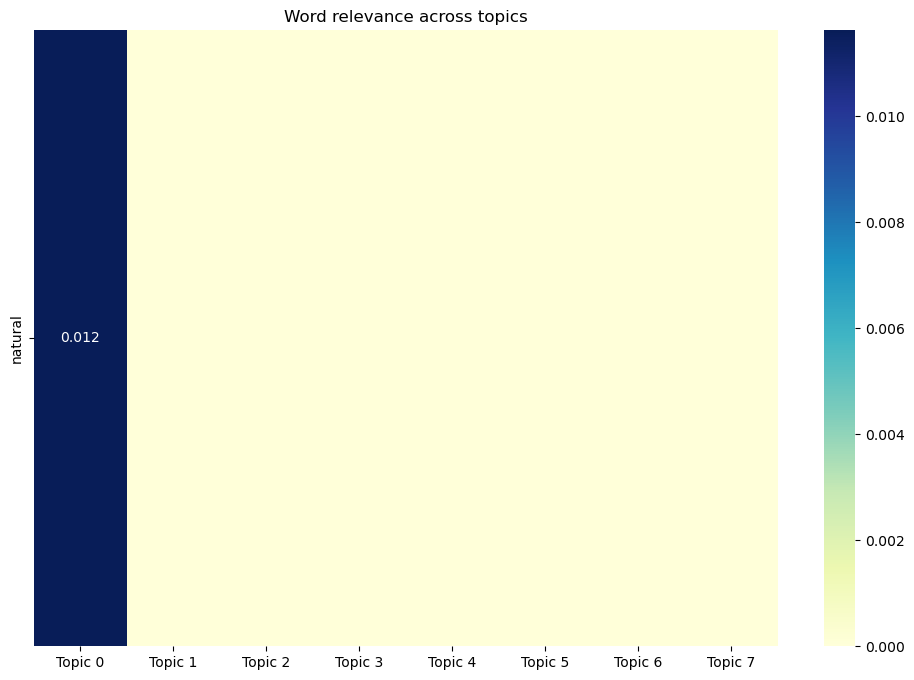

In [200]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# List of words to analyze
words = ['natural']
word_ids = [dictionary.token2id.get(word, None) for word in words]

# Initialize list to store the probabilities
topic_word_probabilities = []

for word_id in word_ids:
    if word_id is not None:
        probs = [prob for _, prob in lda_model.get_term_topics(word_id, minimum_probability=0)]
        # Ensure that we collect probabilities for all topics
        if len(probs) < lda_model.num_topics:
            probs.extend([0] * (lda_model.num_topics - len(probs)))  # Add zeros if some topics are missing
    else:
        probs = [0] * lda_model.num_topics  # If the word is not in the vocabulary, set all probabilities to 0
    topic_word_probabilities.append(probs)

# Convert the list to a DataFrame
df = pd.DataFrame(topic_word_probabilities, index=words, columns=[f"Topic {i}" for i in range(lda_model.num_topics)])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.title('Word relevance across topics')
plt.show()
